In [17]:
!unzip ./anime_dataset.zip

Archive:  ./anime_dataset.zip
warning [./anime_dataset.zip]:  2621173482 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [./anime_dataset.zip]:  start of central directory not found;
  zipfile corrupt.
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


In [9]:
import os
import pickle
import copy
import torch
import torch.nn as nn
import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
import matplotlib.pyplot as plt

from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [10]:
def save_model(model, filename):  # 保存为CPU中可以打开的模型
    state = model.state_dict()
    x = state.copy()
    for key in x:
        x[key] = x[key].clone().cpu()
    torch.save(x, filename)
    
def loadIfExist(model, path='net_new'):
    path += '.pth'
#     print(path)
    if os.path.exists(path):
        model.load_state_dict(torch.load(path))
        print("the latest model has been load")
            

def showimg(images, count):
    images = images.to('cpu')
    images = images.detach().numpy()
    images = images[[3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63]]
    images = 255 * (0.5 * images + 0.5)
    images = images.astype(np.uint8)
    grid_length = int(np.ceil(np.sqrt(images.shape[0])))
    plt.figure(figsize=(4, 4))
    width = images.shape[3]
    gs = gridspec.GridSpec(grid_length, grid_length, wspace=0, hspace=0)
    images = [cv2.cvtColor(image.transpose([1, 2, 0]), cv2.COLOR_BGR2RGB) for image in images]
    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img, cmap=plt.cm.gray)
        plt.axis('off')
        plt.tight_layout()
    # plt.savefig(r'./%d.png' % count, bbox_inches='tight')


3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63

In [11]:
ROOT = 'anime_dataset'


color_list = os.listdir(ROOT)
COLOR2LABEL = dict(zip(color_list, range(len(color_list))))
LABEL2COLOR = dict(zip(range(len(color_list)), color_list))


class Anime_Dataset(Dataset):
    
    def __init__(self, train=True):
        
        color_list = os.listdir(ROOT)
        dir_paths = [os.path.join(ROOT, s) for s in color_list]
        self.paths = []
        for dir_path in dir_paths:
            files = os.listdir(dir_path)
            file_paths = [os.path.join(dir_path,file) for file in files if file.endswith('.jpg')]
            self.paths.extend(file_paths)
        
        
    
    def __getitem__(self, index):
        image = plt.imread(self.paths[index])
        image = Image.resize(image, (128, 128))  # shape=[128, 128, 3]
        image = image.transpose([2, 0, 1])  # shape=[3, 128, 128]
        image = torch.tensor(image, dtype=torch.float32)
        image = image / 128. - 1
        
        color = self.paths[index].split(os.sep)[-2]
        label = torch.tensor(COLOR2LABEL[color], dtype=torch.int64)
        return image, label

    def __len__(self):
        return len(self.paths)

FileNotFoundError: [Errno 2] No such file or directory: '/content/small_dataset'

In [ ]:
def loadAnime(batch_size):
    train_dataset = Anime_Dataset()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    print('dataset has been looded')
    return train_dataset, train_loader


In [ ]:
class discriminator_block(nn.Module):
    def __init__(self, in_channel, out_channel, strides=1):
        super(discriminator_block, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=strides, padding=1, bias=False),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, bias=False),
        )
        self.out = nn.ReLU()
    def forward(self, x):
        out = self.block(x)
        return self.out(out + x)


In [ ]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1), # [N, 32, 64, 64]
            nn.LeakyReLU(0.2, True),
        )
        self.layer2 = nn.Sequential(
            discriminator_block(32, 32),
            nn.LeakyReLU(0.2, True),
            discriminator_block(32, 32),
            nn.LeakyReLU(0.2, True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, 4, stride=2, padding=1), # [N, 64, 32, 32]
            nn.LeakyReLU(0.2, True),
        )
        self.layer4 = nn.Sequential(
            discriminator_block(64, 64),
            nn.LeakyReLU(0.2, True),
            discriminator_block(64, 64),
            nn.LeakyReLU(0.2, True),
            discriminator_block(64, 64),
            nn.LeakyReLU(0.2, True),
            discriminator_block(64, 64),
            nn.LeakyReLU(0.2, True),
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # [N, 128, 16, 16]
            nn.LeakyReLU(0.2, True),
        )
        self.layer6 = nn.Sequential(
            discriminator_block(128, 128),
            nn.LeakyReLU(0.2, True),
            discriminator_block(128, 128),
            nn.LeakyReLU(0.2, True),
            discriminator_block(128, 128),
            nn.LeakyReLU(0.2, True),
            discriminator_block(128, 128),
            nn.LeakyReLU(0.2, True),
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=2, padding=1), # [N, 256, 8, 8]
            nn.LeakyReLU(0.2, True),
        )
        self.layer8 = nn.Sequential(
            discriminator_block(256, 256),
            nn.LeakyReLU(0.2, True),
            discriminator_block(256, 256),
            nn.LeakyReLU(0.2, True),
            discriminator_block(256, 256),
            nn.LeakyReLU(0.2, True),
            discriminator_block(256, 256),
            nn.LeakyReLU(0.2, True),
        )
        self.layer9 = nn.Sequential(
            nn.Conv2d(256, 512, 3, stride=2, padding=1), # [N, 512, 4, 4]
            nn.LeakyReLU(0.2, True),
        )
        self.layer10 = nn.Sequential(
            discriminator_block(512, 512),
            nn.LeakyReLU(0.2, True),
            discriminator_block(512, 512),
            nn.LeakyReLU(0.2, True),
            discriminator_block(512, 512),
            nn.LeakyReLU(0.2, True),
            discriminator_block(512, 512),
            nn.LeakyReLU(0.2, True),
        )
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 1024, 3, stride=2, padding=1), # [N, 1024, 2, 2]
            nn.LeakyReLU(0.2, True),
        )
        self.fc = nn.Sequential(
            nn.Linear(1024 * 2 * 2, 3),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x




In [ ]:
class generator_block(nn.Module):
    def __init__(self, in_channel, out_channel, strides=1):
        super(generator_block, self).__init__()
        self.same_channel = False
        if in_channel == out_channel:
          self.same_channel = True
        self.block = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=strides, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channel)
        )
        if not self.same_channel: # 通道数不同,加一层卷积统一通道数
            self.cb = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=strides, bias=False),
                nn.BatchNorm2d(out_channel)
            )
        self.out = nn.ReLU()
    def forward(self, x):
        out = self.block(x)
        if not self.same_channel:
            x = self.cb(x)
        return self.out(out + x)

In [ ]:
class generator(nn.Module):
    def __init__(self, input_size):
        super(generator, self).__init__()
        self.fc = nn.Linear(input_size, 1024 * 16 * 16)
        self.br = nn.Sequential(
            nn.BatchNorm2d(1024),
            nn.ReLU(True)
        )
        self.adjust = nn.Sequential(
            nn.Conv2d(1024, 64, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(64)
        )
        self.layer1 = nn.Sequential(
            generator_block(1024, 64, strides=1),
            generator_block(64, 64),
            generator_block(64, 64),
            generator_block(64, 64),
            generator_block(64, 64),
            generator_block(64, 64),
            generator_block(64, 64),
            generator_block(64, 64),
            generator_block(64, 64),
            generator_block(64, 64),
            generator_block(64, 64),
            generator_block(64, 64),
            generator_block(64, 64),
            generator_block(64, 64),
            generator_block(64, 64),
            generator_block(64, 64),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False), # [N, 64, 16, 16]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1, bias=False), # [N, 256, 16, 16]
            nn.PixelShuffle(2), # [N, 256, 32, 32]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1, bias=False), # [N, 256, 32, 32]
            nn.PixelShuffle(2), # [N, 256, 64, 64]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1, bias=False), # [N, 256, 64, 64]
            nn.PixelShuffle(2), # [N, 256, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4, bias=False), # [N, 3, 128, 128]
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 1024, 16, 16)
        x = self.br(x)
        x1 = self.layer1(x)
        x1 = self.layer2(x1)
        x = self.adjust(x)
        x = x + x1
        x = self.layer3(x)
        x = self.layer4(x)
        return x


In [85]:
batch_size = 64
trainset, trainloader = loadAnime(batch_size)  # data

dataset has been looded


In [ ]:
criterion = nn.BCELoss()
z_dimension = 300
label_num = len(LABEL2COLOR)
D = discriminator()
G = generator(z_dimension)
D = D.cuda()
G = G.cuda()
loadIfExist(D,'anime_d_1.pth')
loadIfExist(G,'anime_g_1.pth')
d_optimizer = optim.Adam(D.parameters(), lr=0.0003)
g_optimizer = optim.Adam(G.parameters(), lr=0.0003)

Epoch [4/150], d_loss: 0.921376, g_loss: 0.844975 D real: 0.202520, D fake: 0.213169
['gray', 'black', 'gray', 'gray', 'white', 'black', 'gray', 'black', 'black', 'gray', 'white', 'gray', 'white', 'white', 'black', 'gray']


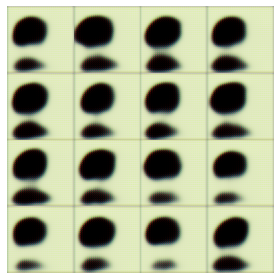

Epoch [5/150], d_loss: 0.955773, g_loss: 0.807296 D real: 0.104217, D fake: 0.119805
['white', 'white', 'black', 'white', 'white', 'gray', 'black', 'white', 'black', 'gray', 'white', 'black', 'white', 'gray', 'gray', 'black']


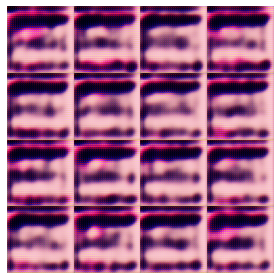

Epoch [6/150], d_loss: 0.872248, g_loss: 0.671171 D real: 0.210774, D fake: 0.171796
['white', 'white', 'gray', 'white', 'black', 'white', 'gray', 'gray', 'white', 'white', 'black', 'black', 'gray', 'gray', 'white', 'black']


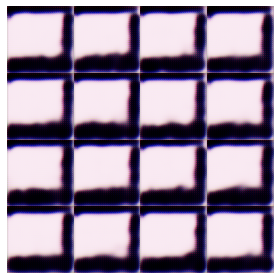

Epoch [7/150], d_loss: 0.890352, g_loss: 0.705503 D real: 0.175267, D fake: 0.170246
['white', 'gray', 'gray', 'gray', 'white', 'white', 'white', 'black', 'white', 'black', 'white', 'gray', 'gray', 'gray', 'gray', 'black']


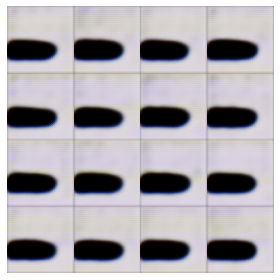

Epoch [8/150], d_loss: 0.906578, g_loss: 0.720741 D real: 0.191752, D fake: 0.192294
['gray', 'black', 'white', 'white', 'black', 'gray', 'white', 'gray', 'black', 'white', 'black', 'black', 'gray', 'white', 'black', 'white']


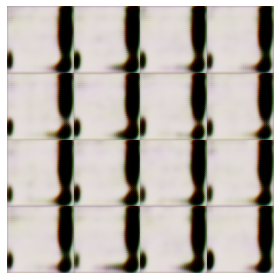

Epoch [9/150], d_loss: 0.903999, g_loss: 0.755765 D real: 0.137694, D fake: 0.133980
['black', 'black', 'white', 'white', 'gray', 'gray', 'white', 'black', 'black', 'black', 'white', 'black', 'white', 'black', 'gray', 'gray']


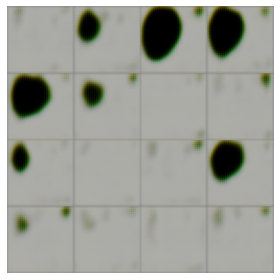

Epoch [10/150], d_loss: 0.907979, g_loss: 0.715384 D real: 0.155900, D fake: 0.162153
['white', 'gray', 'gray', 'black', 'gray', 'black', 'gray', 'white', 'white', 'black', 'gray', 'gray', 'white', 'gray', 'black', 'white']


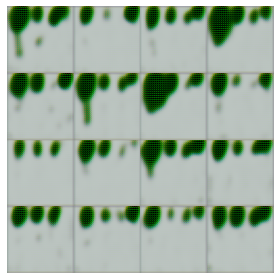

Epoch [11/150], d_loss: 0.961649, g_loss: 0.666404 D real: 0.162240, D fake: 0.206730
['gray', 'gray', 'gray', 'black', 'gray', 'gray', 'white', 'white', 'gray', 'white', 'black', 'gray', 'white', 'black', 'gray', 'black']


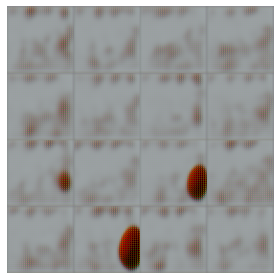

Epoch [12/150], d_loss: 0.906116, g_loss: 0.689006 D real: 0.174871, D fake: 0.177787
['black', 'gray', 'white', 'gray', 'white', 'black', 'white', 'white', 'white', 'black', 'black', 'white', 'black', 'gray', 'black', 'white']


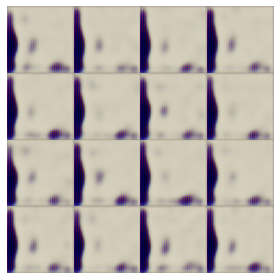

Epoch [13/150], d_loss: 0.896696, g_loss: 0.731002 D real: 0.153390, D fake: 0.151692
['black', 'black', 'gray', 'white', 'white', 'gray', 'gray', 'white', 'black', 'black', 'white', 'gray', 'black', 'gray', 'white', 'white']


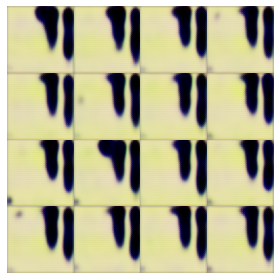

Epoch [14/150], d_loss: 0.639128, g_loss: 0.419338 D real: 0.186392, D fake: 0.154010
['white', 'gray', 'black', 'black', 'white', 'black', 'black', 'white', 'gray', 'gray', 'black', 'white', 'black', 'black', 'black', 'white']


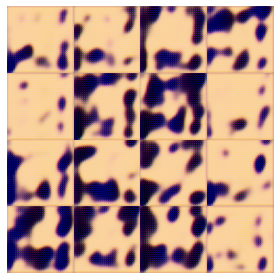

Epoch [15/150], d_loss: 0.599846, g_loss: 0.450309 D real: 0.172526, D fake: 0.127008
['white', 'gray', 'white', 'gray', 'black', 'gray', 'gray', 'white', 'gray', 'white', 'white', 'white', 'black', 'black', 'black', 'white']


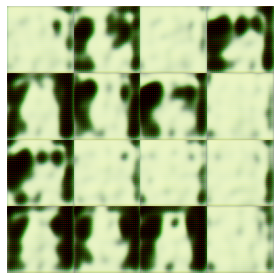

Epoch [16/150], d_loss: 0.643792, g_loss: 0.275951 D real: 0.206209, D fake: 0.171964
['white', 'gray', 'gray', 'gray', 'black', 'white', 'gray', 'gray', 'black', 'black', 'black', 'gray', 'white', 'black', 'black', 'gray']


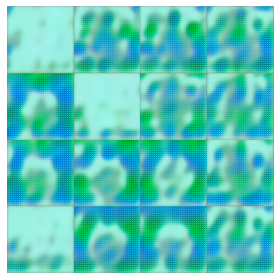

Epoch [17/150], d_loss: 0.615553, g_loss: 0.476573 D real: 0.180685, D fake: 0.112811
['black', 'white', 'black', 'gray', 'gray', 'black', 'gray', 'white', 'black', 'black', 'black', 'black', 'gray', 'gray', 'gray', 'black']


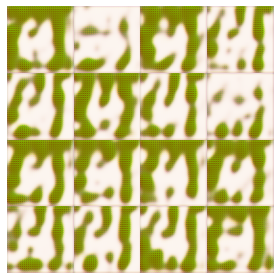

In [ ]:
'''
交替训练的方式训练网络
先训练判别器网络D再训练生成器网络G
不同网络的训练次数是超参数
也可以两个网络训练相同的次数，
这样就可以不用分别训练两个网络
'''
count = 0
# 鉴别器D的训练,固定G的参数
epoch = 150
gepoch = 10
for i in range(epoch):
    for (img, label) in trainloader:
        labels_onehot = np.zeros((batch_size, 3))
        labels_onehot[np.arange(batch_size), label.numpy()] = 1
        img = Variable(img).cuda()
        real_label = Variable(torch.from_numpy(labels_onehot).float()).cuda()  # 真实label为1
        fake_label = Variable(torch.zeros(batch_size, 3)).cuda()  # 假的label为0

        # compute loss of real_img
        real_out = D(img)  # 真实图片送入判别器D输出0~1
        d_loss_real = criterion(real_out, real_label)  # 得到loss
        real_scores = real_out  # 真实图片放入判别器输出越接近1越好

        # compute loss of fake_img
        z = Variable(torch.randn(batch_size, z_dimension)).cuda()  # 随机生成向量
        fake_img = G(z)  # 将向量放入生成网络G生成一张图片
        fake_out = D(fake_img)  # 判别器判断假的图片
        d_loss_fake = criterion(fake_out, fake_label)  # 假的图片的loss
        fake_scores = fake_out  # 假的图片放入判别器输出越接近0越好

        # D bp and optimize
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        # 生成器G的训练compute loss of fake_img
        for j in range(gepoch):
            z = torch.randn(batch_size, z_dimension-label_num)  # 随机生成向量
            z = np.concatenate((z.numpy(), labels_onehot), axis=1)
            z = Variable(torch.from_numpy(z).float()).cuda()
            fake_img = G(z)  # 将向量放入生成网络G生成一张图片
            output = D(fake_img)  # 经过判别器得到结果
            g_loss = criterion(output, real_label)  # 得到假的图片与真实标签的loss
            # bp and optimize
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            temp = real_label
    print('Epoch [{}/{}], d_loss: {:.6f}, g_loss: {:.6f} '
          'D real: {:.6f}, D fake: {:.6f}'.format(
        (i+1 + 3), epoch, d_loss.item(), g_loss.item(),
        real_scores.data.mean(), fake_scores.data.mean()))
    if (d_loss.item() - g_loss.item()) > 2 * (d_loss.item() + g_loss.item())/5:
      gepoch = 4
    elif (g_loss.item() - d_loss.item()) > 2 * (d_loss.item() + g_loss.item())/5:
      gepoch = 10
    else:
      gepoch = 7
    temp = temp.to('cpu')
    _, x = torch.max(temp, 1)
    x = x.cpu().numpy()[[3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63]]
    color = [LABEL2COLOR[c] for c in x]
    print(color)
    showimg(fake_img, count)
    plt.show()
    count += 1


In [ ]:
save_model(D,'anime_d_2.pth')
save_model(G,'anime_g_2.pth')

In [ ]:
batch_size = 16


def show(images):
    images = images.detach().numpy()
    images = 255 * (0.5 * images + 0.5)
    images = images.astype(np.uint8)
    plt.figure(figsize=(4, 4))
    width = images.shape[2]
    gs = gridspec.GridSpec(1, batch_size, wspace=0, hspace=0)
    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape(width, width), cmap=plt.cm.gray)
        plt.axis('off')
        plt.tight_layout()
    plt.tight_layout()
    # plt.savefig(r'%d.png' % count, bbox_inches='tight')
    return width


def show_all(images_all):
    x = images_all[0]
    for i in range(1, len(images_all), 1):
        x = np.concatenate((x, images_all[i]), 0)
    print(x.shape)
    x = 255 * (0.5 * x + 0.5)
    x = x.astype(np.uint8)
    plt.figure(figsize=(9, 10))
    width = x.shape[2]
    gs = gridspec.GridSpec(10, batch_size, wspace=0, hspace=0)
    for i, img in enumerate(x):
        ax = plt.subplot(gs[i])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape(width, width), cmap=plt.cm.gray)
        plt.axis('off')
        plt.tight_layout()

    # 导入相应的模型


z_dimension = 110
D = discriminator()
G = generator(z_dimension, 3136)  # 1*56*56
D.load_state_dict(torch.load(r'./CGAN/Discriminator.pkl'))
G.load_state_dict(torch.load(r'./CGAN/Generator.pkl'))
# 依次生成0到9
lis = []
for i in range(10):
    z = torch.randn((batch_size, 100))  # 随机生成向量
    x = np.zeros((batch_size, 10))
    x[:, i] = 1
    z = np.concatenate((z.numpy(), x), 1)
    z = torch.from_numpy(z).float()
    fake_img = G(z)  # 将向量放入生成网络G生成一张图片
    lis.append(fake_img.detach().numpy())
    output = D(fake_img)  # 经过判别器得到结果
    show(fake_img)
    plt.savefig('./%d.png' % i, bbox_inches='tight')

show_all(lis)
plt.savefig('./all.png', bbox_inches='tight')
plt.show()

NameError: name 'discriminator' is not defined

In [ ]:
# # 创建虚拟桌面
# screen -S xxx
# #实时查看日志，可以把日志保存到指定文件中，然后执行：
# tail -fn 1000 xxxx